In [1]:
import numpy as np
from numpy.random import RandomState, default_rng

import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import math

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc, recall_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, classification_report

from hyperopt import hp, fmin, STATUS_OK, tpe
from hyperopt.early_stop import no_progress_loss

## Creating Datasets
* Small: Top 5 non-text based featuress from 1% dataset
* Medium: Top 24 non-text based features from 5% dataset
* Large: Top 45 non-text based features from 10% dataset
* Validation: Top 5,24,45 non-text based features from 1% dataset

All datasets contain two classes (i.e. attack or binary) and 47 features. We then select the top 5 features for each dataset.

Small, medium and large will be split into train and test datasets. Train is used to create detectors and test is used for the evaluation function. Validation is used to optimize detecto radius with Hyperopt.

In [2]:
#Creating the datasets
df_1percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")
df_5percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.05percent_2classes.csv")
df_10percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_2classes.csv")

df_val = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")

In [3]:
print(df_1percent.shape, df_5percent.shape, df_10percent.shape, df_val.shape)

(466869, 47) (2334325, 47) (4668665, 47) (466761, 47)


In [4]:
# Features
top5_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top5.csv")["Feature"])
top24_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top24.csv")["Feature"])
topall_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/topall.csv")["Feature"])

top5_feats.append("benign")
top24_feats.append("benign")
topall_feats.append("benign")

In [5]:
df_small = df_1percent[top5_feats]
df_med = df_5percent[top24_feats]
df_large = df_10percent[topall_feats]

df_val_small = df_val[top5_feats]
df_val_med = df_val[top24_feats]
df_val_large = df_val[topall_feats]

In [6]:
print(df_small.shape, df_med.shape, df_large.shape)
print(df_val_small.shape, df_val_med.shape, df_val_large.shape)

(466869, 6) (2334325, 25) (4668665, 46)
(466761, 6) (466761, 25) (466761, 46)


# Preprocessing
1. Normalize using Sci-Kit Learn's StandardScaler()
2. Split into detectors, and scaled attacks and scaled benigns (for testing)

In [7]:
def preprocessing(df_main, df_val):
    X = df_main.drop("benign", axis = 1)
    y = df_main["benign"].astype(np.float32)
    
    ratio_att_to_ben = (y.value_counts()[0.0])/(y.value_counts()[1.0])
    
    X_val = df_val.drop("benign", axis = 1)
    y_val = df_val["benign"].astype(np.float32)
    
    val_ratio_att_to_ben = (y_val.value_counts()[0.0])/(y_val.value_counts()[1.0])
    
    # Convert to numpy
    X = X.to_numpy().astype(np.float32) #All data w/o labels
    y = y.to_numpy().astype(np.float32) #All labels
    
    # Normalization
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(X)
    
    benigns_scaled = data_scaled[y.squeeze() == True, :]
    attacks_scaled = data_scaled[y.squeeze() == False, :]
    
    print(f"scaler mean: {scaler.mean_.astype(np.float32)}, scaler var: {scaler.var_.astype(np.float32)}")
    
    # Normalization of Validation Dataset
    val_scaler = ColumnTransformer([
        ('somename', StandardScaler(), X_val.columns)
    ], remainder='passthrough')
    scaled_val = val_scaler.fit_transform(df_val)
    
    scaled_benigns_train, scaled_benigns_test = train_test_split(benigns_scaled, test_size=0.3, random_state = 42)
    scaled_attacks_train, scaled_attacks_test = train_test_split(attacks_scaled, test_size=0.3, random_state = 42)
    
    return scaled_benigns_train, scaled_benigns_test, scaled_attacks_train, scaled_attacks_test, scaled_val, int(ratio_att_to_ben), int(val_ratio_att_to_ben)

In [8]:
# Small Dataset
small_ben_train, small_ben_test, small_att_train, small_att_test, small_val, small_ratio_att_to_ben, small_val_ratio_att_to_ben = preprocessing(df_small, df_val_small)
print(small_ben_train.shape, small_ben_test.shape, small_att_train.shape, small_att_test.shape)

# Medium Dataset
med_ben_train, med_ben_test, med_att_train, med_att_test, med_val, med_ratio_att_to_ben, med_val_ratio_att_to_ben = preprocessing(df_med, df_val_med)
print(med_ben_train.shape, med_ben_test.shape, med_att_train.shape, med_att_test.shape)

# Large Dataset
large_ben_train, large_ben_test, large_att_train, large_att_test, large_val, large_ratio_att_to_ben, large_val_ratio_att_to_ben = preprocessing(df_large, df_val_large)
print(large_ben_train.shape, large_ben_test.shape, large_att_train.shape, large_att_test.shape)

scaler mean: [8.3157144e+07 7.6943680e+04 1.3118273e+01 3.8499920e+01 1.8166219e+02], scaler var: [2.9066282e+14 2.1407808e+11 7.4370697e+01 1.0545658e+05 2.7581962e+05]
(7686, 5) (3295, 5) (319121, 5) (136767, 5)
scaler mean: [8.31867200e+07 7.67192031e+04 1.31205196e+01 3.83366890e+01
 1.81906525e+02 1.24665955e+02 5.65363550e+00 1.24624290e+02
 6.17433643e+00 9.64782238e-02 1.30702576e+03 9.15912704e+01
 8.93214160e+03 8.93214160e+03 3.30482155e-01 4.70852165e+01
 6.63340912e+01 3.06868145e+04 3.33165359e+01 9.49866199e+00
 7.42634386e-02 1.41516937e+02 5.50548881e-02 3.76982644e-05], scaler var: [2.90543733e+14 2.11809174e+11 7.43846207e+01 1.04806289e+05
 2.74205312e+05 5.83438203e+04 6.57023203e+04 5.79748320e+04
 5.05823730e+03 5.42926826e-02 6.76950700e+06 1.94881074e+04
 9.60522240e+09 9.60522240e+09 4.40479666e-01 5.12790742e+04
 1.94201294e+02 9.73378109e+10 2.56325703e+04 6.70799196e-01
 1.20611764e-01 4.43793762e+02 5.20238467e-02 3.76968419e-05]
(38437, 24) (16474, 24) (1

# Generate Detectors

In [9]:
def affinity(v1 : np.ndarray, v2 : np.ndarray):
    ''' Manhattan distance between vectors '''
    return np.sum(np.abs(v1 - v2), axis=-1)

In [10]:
def gen_rand_like(dim : tuple, ben_data, data = np.ndarray) -> np.ndarray:
    ''' 
    Generates random vectors with the same range as model data
    
    Parameters
    --------------
    dim: the dimensions of the random vectors to create.
    data: the benign data to get the range from (hardcoded for performance gains)
    '''
    HARDCODE_RANGE = np.max(ben_data, axis=0) - np.min(ben_data, axis=0) 
    
    return np.random.rand(*dim) * HARDCODE_RANGE

### To improve detectors:
1. If any detector has another detector within threshold, replace it. Selectively fixes detectors that are close together, but no incentive to make detectors close to datapoints.
2. If any detector has less than k datapoints within threshold, replace it. Selectively removes detectors far from datapoints, but could end up with all detectors in one place.

In [11]:
def improve_detectors_opt(data : np.ndarray, detectors : np.ndarray, 
                          det2det : float, dat2det : float, max_iters : int) -> np.ndarray:
    
    # On every iteration, track affinity
    aff_history = []
    for i in range(max_iters):
        print(".", end="")
        
        # Check distance between detectors
        aff = affinity(np.expand_dims(detectors, axis=1), detectors)
        second_lowest = np.partition(aff, 1, axis=1)[:, 1]
        to_remove = second_lowest < det2det
        
        # Update detectors that are too close
        new_det_shape = (np.sum(to_remove), detectors.shape[-1])
        detectors[to_remove, :] = gen_rand_like(new_det_shape, data)
        
        # Check datapoints without nearby detectors
        aff = affinity(np.expand_dims(data, axis=1), detectors)
        aff = np.min(aff, axis=1)
        aff_history.append(np.mean(aff))
        
        # Update random detectors to relocate to datapoint
        to_update = np.where(aff > dat2det)[0][: detectors.shape[0]]
        detectors[:to_update.shape[0]] = data[to_update, :]
    
    return detectors, aff_history

In [12]:
# Set hyperparameters
NUM_DETECTORS = 100
det2det = 1 * 10**6
dat2det = 1 * 10**8
max_iters = 25

# Small Dataset
init_vec = gen_rand_like((NUM_DETECTORS, small_ben_train.shape[-1]), small_ben_train)
DETECTORS_S, aff_history = improve_detectors_opt(small_ben_train, init_vec, det2det, dat2det, max_iters)

# Medium Dataset
init_vec = gen_rand_like((NUM_DETECTORS, med_ben_train.shape[-1]), med_ben_train)
DETECTORS_M, aff_history = improve_detectors_opt(med_ben_train, init_vec, det2det, dat2det, max_iters)

# Large Dataset
init_vec = gen_rand_like((NUM_DETECTORS, large_ben_train.shape[-1]), large_ben_train)
DETECTORS_L, aff_history = improve_detectors_opt(large_ben_train, init_vec, det2det, dat2det, max_iters)

...........................................................................

In [13]:
# Set number of detectors, test data points and validation data points

NUM_BENIGN = 1000
NUM_VAL = 10000

# Small Dataset
BENIGN_TEST_S = small_ben_test[:NUM_BENIGN]
ATTACK_TEST_S = small_att_test[:NUM_BENIGN*small_ratio_att_to_ben]

# Medium Dataset
BENIGN_TEST_M = med_ben_test[:NUM_BENIGN]
ATTACK_TEST_M = med_att_test[:NUM_BENIGN*med_ratio_att_to_ben]

# Large Dataset
BENIGN_TEST_L = large_ben_test[:NUM_BENIGN]
ATTACK_TEST_L = large_att_test[:NUM_BENIGN*large_ratio_att_to_ben]

In [14]:
NUM_BENIGN_VAL = 1000

fltr_ben = np.asarray([1.])
fltr_att = np.asarray([0.])

n_sm = small_val.shape[-1] - 1
n_md = med_val.shape[-1] - 1
n_lg = large_val.shape[-1] - 1

val_ben_sm = np.delete(small_val[np.in1d(small_val[:,n_sm], fltr_ben)], n_sm, 1)[:NUM_BENIGN_VAL]
val_att_sm = np.delete(small_val[np.in1d(small_val[:,n_sm], fltr_att)], n_sm, 1)[:NUM_BENIGN_VAL*small_val_ratio_att_to_ben]

val_ben_md = np.delete(med_val[np.in1d(med_val[:,n_md], fltr_ben)], n_md, 1)[:NUM_BENIGN_VAL]
val_att_md = np.delete(med_val[np.in1d(med_val[:,n_md], fltr_att)], n_md, 1)[:NUM_BENIGN_VAL*med_val_ratio_att_to_ben]

val_ben_lg = np.delete(large_val[np.in1d(large_val[:,n_lg], fltr_ben)], n_lg, 1)[:NUM_BENIGN_VAL]
val_att_lg = np.delete(large_val[np.in1d(large_val[:,n_lg], fltr_att)], n_lg, 1)[:NUM_BENIGN_VAL*large_val_ratio_att_to_ben]

print(val_ben_sm)
print(val_att_sm)

[[ 4.89251975  1.40479982  5.36891253  1.80875071  8.00727335]
 [-4.88278142 -0.15830568  0.01076975 -0.07873116 -0.03413056]
 [-4.88278142  0.34706964  1.88565204  1.86067173  1.54081798]
 ...
 [-4.88278142  4.13670723  2.26400822  7.60558015  3.22920978]
 [ 4.89257082  0.27012998  5.3322957   0.48323755  5.26493872]
 [-4.88278142  2.95214505  5.48846425  4.06884227  4.44223833]]
[[-0.0050718  -0.1666431  -0.31604226 -0.11843548 -0.24245708]
 [ 0.01090782 -0.16658025 -0.31604226 -0.11843548 -0.24245708]
 [-0.01116059 -0.16663226 -0.3159238  -0.11843548 -0.24222982]
 ...
 [ 0.00992159 -0.1666431  -0.31604226 -0.11843548 -0.24245708]
 [-0.00283458 -0.16676013 -0.4570232  -0.11843548 -0.26245643]
 [ 0.00814779 -0.16659975 -0.27905893 -0.11843548 -0.18245904]]


# P-R Curve and Optimal Radius Search

In [15]:
def nsa(r, detrs, ben, att):
    
    def affinity(v1 : np.ndarray, v2 : np.ndarray):
        ''' Manhattan distance between vectors '''
        return np.sum(np.abs(v1 - v2), axis=-1)

    #True Positive: Self correctly classified
    TP = 0
    #False Positive: Non-Self incorrectly classified
    FP = 0
    #True Negative: Non-Self correctly classified
    TN = 0
    #False Negative: Self incorrectly classified
    FN = 0

    # Test benign data
    for t in ben:
        for i in range(0, len(detrs)-1):
          aff = affinity(t, detrs[i])
          if aff < r:
            TP += 1
            break
    FN = len(ben) - TP

    # Test attack data
    for t in att:
        for i in range(0, len(detrs)-1):
          aff = affinity(t, detrs[i])
          if aff < r:
            FP += 1
            break
    TN = len(att) - FP

    print(f"Results for r = {r} | TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

    detection_rate = TN/(TN+FP)
    false_alarm_rate = FN/(FN+TP)
    
    if (TP + FP) != 0.0:
        precision = TP/(TP + FP)
    if (TP + FP) == 0.0:
        precision = 0
    if (TP + FN) != 0.0:
        recall = TP/(TP + FN)
    if (TP + FN) == 0.0:
        recall = 0

    loss = 1 - (detection_rate - false_alarm_rate)

    return loss, detection_rate, false_alarm_rate, precision, recall

In [16]:
def pr_curve(min_radius, max_radius, num_steps, detrs, ben, att):

    # For radius-loss curve
    r_values = np.linspace(min_radius,max_radius, num_steps)
    loss_values = []

    # For detection rate - false alarm rate curve
    detection_rates = []
    false_alarm_rates = []

    # For PR curve
    precisions = []
    recalls = []

    for r in r_values:
        loss, detection_rate, false_alarm_rate, precision, recall = nsa(r, detrs, ben, att)
        loss_values.append(loss)
        detection_rates.append(detection_rate)
        false_alarm_rates.append(false_alarm_rate)
        precisions.append(precision)
        recalls.append(recall)
    
    figure, axis = plt.subplots(1, 3, constrained_layout=True)
    
    # For radius-loss curve
    axis[0].plot(r_values, loss_values) 
    axis[0].set_title("Loss Curve")
    axis[0].set_xlabel("Radius")
    axis[0].set_ylabel("Loss")
    
    # For detection rate - false alarm rate curve
    axis[1].plot(false_alarm_rates, detection_rates) 
    axis[1].set_title("Det. Rate - F. Alarm Rate") 
    axis[1].set_xlabel("F. Alarm Rate")
    axis[1].set_ylabel("Det. Rate")
    
    # For Precision Recall curve
    axis[2].plot(recalls, precisions) 
    axis[2].set_title("P-R Curve") 
    axis[2].set_xlabel("Recall")
    axis[2].set_ylabel("Precision")
    
    axis[0].set_box_aspect(1)
    axis[1].set_box_aspect(1)
    axis[2].set_box_aspect(1)
    
    plt.show() 
    
    optimal_radius = r_values[loss_values.index(min(loss_values))]
    
    sorted_indices = sorted(range(len(recalls)), key=lambda k: recalls[k])
    precisions_ord = [precisions[i] for i in sorted_indices]
    recalls_ord = [recalls[i] for i in sorted_indices]
    
    prauc = auc(recalls_ord, precisions_ord)
        
    return optimal_radius, prauc

In [17]:
MIN_RADIUS = 0.001
MAX_RADIUS = 70.0
NUM_STEPS = 50

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 1.429551020408163 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 2.858102040816326 | TN: 41000, FP: 0, FN: 999, TP: 1
Results for r = 4.28665306122449 | TN: 40996, FP: 4, FN: 994, TP: 6
Results for r = 5.715204081632653 | TN: 40985, FP: 15, FN: 975, TP: 25
Results for r = 7.143755102040815 | TN: 40965, FP: 35, FN: 929, TP: 71
Results for r = 8.572306122448978 | TN: 40912, FP: 88, FN: 821, TP: 179
Results for r = 10.000857142857141 | TN: 40867, FP: 133, FN: 722, TP: 278
Results for r = 11.429408163265304 | TN: 40783, FP: 217, FN: 631, TP: 369
Results for r = 12.857959183673467 | TN: 40239, FP: 761, FN: 545, TP: 455
Results for r = 14.28651020408163 | TN: 39227, FP: 1773, FN: 477, TP: 523
Results for r = 15.715061224489792 | TN: 38065, FP: 2935, FN: 428, TP: 572
Results for r = 17.14361224489796 | TN: 37138, FP: 3862, FN: 378, TP: 622
Results for r = 18.57216326530612 | TN: 36127, FP: 4873, FN: 307, TP: 693
Re

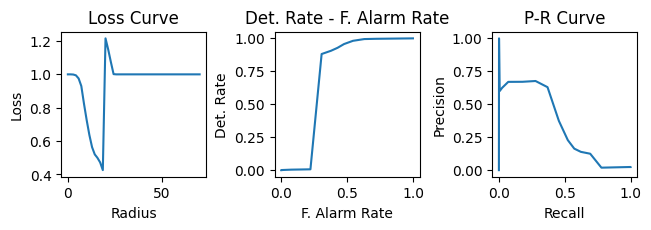

Optimal Radius for small dataset: 18.57216326530612
PRAUC for small dataset: 0.3453008079256957


In [18]:
# Small Dataset
best_radius_S, prauc_S = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_S, val_ben_sm, val_att_sm)
print(f"Optimal Radius for small dataset: {best_radius_S}")
print(f"PRAUC for small dataset: {prauc_S}")

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 1.429551020408163 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 2.858102040816326 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 4.28665306122449 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 5.715204081632653 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 7.143755102040815 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 8.572306122448978 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 10.000857142857141 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 11.429408163265304 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 12.857959183673467 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 14.28651020408163 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 15.715061224489792 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 17.14361224489796 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 18.57216326530612 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 20.0007142857

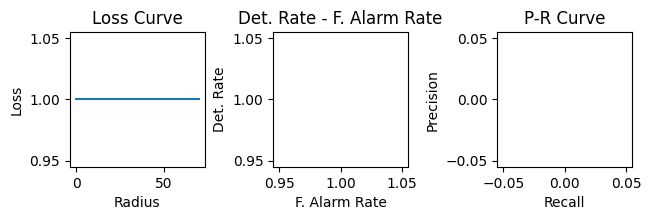

Optimal Radius for medium dataset: 0.001
PRAUC for medium dataset: 0.0


In [19]:
# Medium Dataset
best_radius_M, prauc_M = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_M, val_ben_md, val_att_md)
print(f"Optimal Radius for medium dataset: {best_radius_M}")
print(f"PRAUC for medium dataset: {prauc_M}")

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 1.429551020408163 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 2.858102040816326 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 4.28665306122449 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 5.715204081632653 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 7.143755102040815 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 8.572306122448978 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 10.000857142857141 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 11.429408163265304 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 12.857959183673467 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 14.28651020408163 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 15.715061224489792 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 17.14361224489796 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 18.57216326530612 | TN: 41000, FP: 0, FN: 1000, TP: 0
Results for r = 20.0007142857

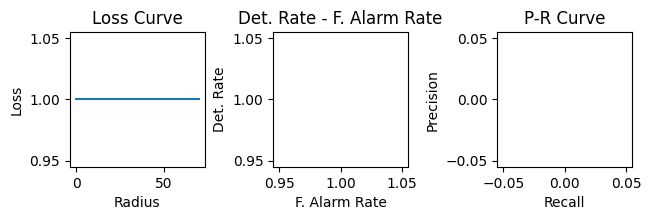

Optimal Radius for large dataset: 0.001
PRAUC for large dataset: 0.0


In [20]:
# Large Dataset
best_radius_L, prauc_L = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_L, val_ben_lg, val_att_lg)
print(f"Optimal Radius for large dataset: {best_radius_L}")
print(f"PRAUC for large dataset: {prauc_L}")

# Evaluation Function

In [21]:
def evaluate(optimal_radius, detrs, att_test, ben_test):
    
    def affinity(v1 : np.ndarray, v2 : np.ndarray):
        ''' Manhattan distance between vectors '''
        return np.sum(np.abs(v1 - v2), axis=-1)
    
    y_attack_labels = np.zeros((1, len(att_test)), dtype=np.int8)
    #print(y_attack_labels.shape)
    y_ben_labels = np.ones((1, len(ben_test)), dtype=np.int8)
    #print(y_ben_labels.shape)
    y_test = np.concatenate((y_attack_labels, y_ben_labels), axis=1)[0]
    #print(y_test.shape)

    pred = []
    done = False

    for inst in att_test:
        done = False
        for i in range(0, len(detrs)-1):
              aff = affinity(inst, detrs[i])
              if aff < optimal_radius:
                pred.append(1) # Predicted benign
                done = True
                break
        if not done:
            pred.append(0) # Predicted attack

    done = False
    for inst in ben_test:
        done = False
        for i in range(0, len(detrs)-1):
              aff = affinity(inst, detrs[i])
              if aff < optimal_radius:
                pred.append(1) # Predicted benign
                done = True
                break
        if not done:
            pred.append(0) # Predicted attack

    y_pred = np.asarray(pred, dtype=np.int8)

    print(classification_report(y_test, y_pred, digits = 3, target_names = ["attack", "benign"]))

In [22]:
# Small Dataset
evaluate(best_radius_S, DETECTORS_S, ATTACK_TEST_S, BENIGN_TEST_S)

              precision    recall  f1-score   support

      attack      0.992     0.882     0.934     41000
      benign      0.129     0.715     0.218      1000

    accuracy                          0.878     42000
   macro avg      0.560     0.798     0.576     42000
weighted avg      0.972     0.878     0.917     42000



In [23]:
# Medium Dataset
evaluate(best_radius_M, DETECTORS_M, ATTACK_TEST_M, BENIGN_TEST_M)

              precision    recall  f1-score   support

      attack      0.976     1.000     0.988     41000
      benign      0.000     0.000     0.000      1000

    accuracy                          0.976     42000
   macro avg      0.488     0.500     0.494     42000
weighted avg      0.953     0.976     0.964     42000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Large Dataset
evaluate(best_radius_L, DETECTORS_L, ATTACK_TEST_L, BENIGN_TEST_L)

              precision    recall  f1-score   support

      attack      0.976     1.000     0.988     41000
      benign      0.000     0.000     0.000      1000

    accuracy                          0.976     42000
   macro avg      0.488     0.500     0.494     42000
weighted avg      0.953     0.976     0.964     42000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Export Detectors

In [25]:
#Get rid of [] in the txt file before copying to cpp file

# Small Dataset
interm_S = [list(n) for n in DETECTORS_S]
out_S = repr(list(itertools.chain.from_iterable(interm_S)))
with open("detectors_S.txt", "w") as f:
    f.write(out_S)
    
# Medium Dataset
interm_M = [list(n) for n in DETECTORS_M]
out_M = repr(list(itertools.chain.from_iterable(interm_M)))
with open("detectors_M.txt", "w") as f:
    f.write(out_M)

# Large Dataset
interm_L = [list(n) for n in DETECTORS_L]
out_L = repr(list(itertools.chain.from_iterable(interm_L)))
with open("detectors_L.txt", "w") as f:
    f.write(out_L)